Using backend: pytorch

C:\Users\Administrator\anaconda3\envs\tf2\lib\site-packages\skopt\sampler\sobol.py:250: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+25002=25002. 
  total_n_samples))
C:\Users\Administrator\anaconda3\envs\tf2\lib\site-packages\skopt\sampler\sobol.py:250: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+5002=5002. 
  total_n_samples))


Compiling model...
'compile' took 0.000190 s

Training model...

Step      Train loss              Test loss               Test metric
0         [6.23e+00, 1.13e-02]    [6.23e+00, 1.13e-02]    []  
1000      [2.14e-02, 5.99e-02]    [2.14e-02, 5.99e-02]    []  
2000      [1.62e-02, 5.69e-02]    [1.62e-02, 5.69e-02]    []  
3000      [1.24e-02, 5.43e-02]    [1.24e-02, 5.43e-02]    []  
4000      [7.82e-03, 5.17e-02]    [7.82e-03, 5.17e-02]    []  
5000      [5.37e-03, 4.98e-02]    [5.37e-03, 4.98e-02]    []  
6000      [5.15e-03, 4.72e-02]    [5.15e-03, 4.72e-02]    []  
7000      [8.28e-03, 3.64e-02]    [8.28e-03, 3.64e-02]    []  
8000      [1.03e-02, 3.01e-02]    [1.03e-02, 3.01e-02]    []  
9000      [1.10e-02, 2.40e-02]    [1.10e-02, 2.40e-02]    []  
10000     [8.19e-03, 1.63e-02]    [8.19e-03, 1.63e-02]    []  
11000     [6.37e-03, 1.21e-02]    [6.37e-03, 1.21e-02]    []  
12000     [5.19e-03, 9.41e-03]    [5.19e-03, 9.41e-03]    []  
13000     [4.54e-03, 6.85e-03]    [4.54e-03, 6

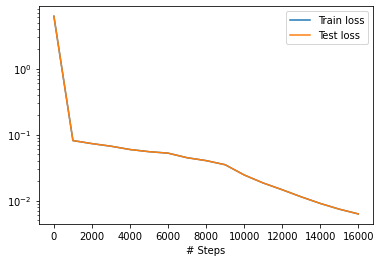

In [1]:
# -*- coding: utf-8 -*-
"""
Created on Mon Mar 21 20:38:19 2022
高斯光束的情况，Rop = Ropz * exp(x,y)
Rop调高点，好看。40有点不够，在COMSOL中也确认下。

决定用torch作为backend，tensorflow搞了两天，解决不了转numpy的问题。因为tf1.0版本，session的创建在函数内部，不好传递出来。不如直接整torch

@author: Administrator
"""

"""Backend supported: tensorflow.compat.v1, torch"""
import deepxde as dde
import numpy as np
#from deepxde.backend import tf
#from deepxde.backend import torch
import torch
from scipy.special import gamma

#import mayavi.mlab as mlab
import matplotlib.pyplot as plt

from draw_counter import random_sphere_points, uniform_sample_points
from PIL import Image

torch.set_default_tensor_type(torch.cuda.FloatTensor)


## 单位统一至cm，定义各个参数
D = 0.585
Rsd = 17.5573
Rwall = 2.654
rpump = 0.75
q = 5
rcell = 1.5

Rrel = Rsd + q*Rwall
I = 25*1e-3*1e4 # kg*(cm)^2/s^3
T = 170
k1 = 10**(-20)*10**8 # kg*cm^4/s^2
k2 = 10**(-17)*10**4 # cm^2
k3 = 1 # cm^-3
sigm = 2.34601*10**(-13) # cm^2

Rop0 = 40


# def fpde(x, y, int_mat):
#     """\int_theta D_theta^alpha u(x)"""
#     if isinstance(int_mat, (list, tuple)) and len(int_mat) == 3:
#         int_mat = tf.SparseTensor(*int_mat)
#         lhs = tf.sparse_tensor_dense_matmul(int_mat, y)
#     else:
#         lhs = tf.matmul(int_mat, y)
#     lhs = lhs[:, 0]
#     lhs *= gamma((1 - alpha) / 2) * gamma((3 + alpha) / 2) / (2 * np.pi ** 2)
#     x = x[: tf.size(lhs)]
#     rhs = (
#         2 ** alpha
#         * gamma(2 + alpha / 2)
#         * gamma((3 + alpha) / 2)
#         / gamma(3 / 2)
#         * (1 - (1 + alpha / 3) * tf.reduce_sum(x ** 2, axis=1))
#     )
#     return lhs - rhs

def bloch_pde(x_in, y_in):
    ''' x_in: (x,y,z) axis
        y_in: Pz polarization
    '''
    x_in_copy = x_in.detach().cpu().numpy()
    x = x_in_copy[:, 0:1]
    y = x_in_copy[:, 1:2]
    z = x_in_copy[:, 2:3]
    
#     sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph())
#     x_arr = x.eval(session=sess)
    dy_xx = dde.grad.hessian(y_in, x_in, i=0, j=0)
    dy_yy = dde.grad.hessian(y_in, x_in, i=1, j=1)
    dy_zz = dde.grad.hessian(y_in, x_in, i=2, j=2) # dy/dxidxj
    
    Rop = Rop0 * np.exp(-2*(x**2+y**2)/rpump**2)
    Rop = torch.from_numpy(Rop).cuda()
    #Rop = Rop0
    
    return -D*(dy_xx+dy_yy+dy_zz) + ((Rop+Rsd)/q+Rwall)*y_in - Rop/q

# def func(x):
#     return (np.abs(1 - np.linalg.norm(x, axis=1, keepdims=True) ** 2)) ** (
#         1 + alpha / 2
#     )

def func_boundary(x_in, Pz, numpy_X):
    x_in_copy = x_in.detach().cpu().numpy()
    x = x_in_copy[:, 0:1]
    y = x_in_copy[:, 1:2]
    z = x_in_copy[:, 2:3]
    
    dPz_x = dde.grad.jacobian(Pz, x_in, i=0, j=0) # This is right
    dPz_y = dde.grad.jacobian(Pz, x_in, i=0, j=1)
    dPz_z = dde.grad.jacobian(Pz, x_in, i=0, j=2)
    
    Rop = Rop0 * np.exp(-2*(x**2+y**2)/rpump**2)
    
    second_term = np.sqrt(1/2*np.abs(Rop*D))
    
    # tranfer back to torch.tensor
    second_term = torch.from_numpy(second_term).cuda()
    Rop = torch.from_numpy(Rop).cuda()
    x = torch.from_numpy(x).cuda()
    y = torch.from_numpy(y).cuda()
    z = torch.from_numpy(z).cuda()
    
    return (D/rcell*(x*dPz_x + y*dPz_y + z*dPz_z) + Pz*second_term)


## 实验不同的边界条件，20220504
# def func_boundary(x_in):    
    
#     return 0

geom = dde.geometry.geometry_3d.Sphere([0, 0, 0], rcell)
#bc = dde.icbc.DirichletBC(geom, func_boundary, lambda _, on_boundary: on_boundary)

#bc = dde.icbc.RobinBC(geom, func_boundary, lambda _, on_boundary: on_boundary)
bc = dde.icbc.OperatorBC(geom, func_boundary, lambda _, on_boundary: on_boundary) # 函数调研下，operatorBC

# data = dde.data.FPDE(
#     geom,
#     fpde,
#     alpha,
#     bc,
#     [8, 8, 100],
#     num_domain=256,
#     num_boundary=1,
#     solution=func,
# )
## 硬性约束，一种。函数不一定好写，涉及到scipy的lambert
## 第二种，边界条件的判断问题？是不是不能判断边界条件了。
data = dde.data.PDE(geom, bloch_pde, bc, num_domain=25000, num_boundary=5000)

net = dde.nn.FNN([3] + [50] * 4 + [1], "tanh", "Glorot normal")
# net.apply_output_transform(
#     lambda x, y: (1 - tf.reduce_sum(x ** 2, axis=1, keepdims=True)) * y
# )

model = dde.Model(data, net)
model.compile("adam", lr=1e-4)
#losshistory, train_state = model.train(epochs=8000, model_save_path='Bloch_Rop_v1')
losshistory, train_state = model.train(epochs=16000)
dde.saveplot(losshistory, train_state, issave=True, isplot=True)


# #z_axis_list = [1.2, 0.8, 0.4, -0.4, -0.8, -1.2]
# z_axis_list = [0.8, 0.4, 0, -0.4, -0.8]
# for z_axis in z_axis_list:
#     figure = plt.figure() 
#     z_axis = z_axis * 1e-2
#     X = random_sphere_points(z= z_axis)
#     y_pred = model.predict(X)[:, 0]
#     np.save('./result/axes_{}'.format(z_axis), X)
#     np.save('./result/pred_{}'.format(z_axis), y_pred)
    
#     x_axis, y_axis = X[:, 0], X[:, 1]
#     plt.scatter(x_axis, y_axis, s=50, c= y_pred, cmap='rainbow', linewidth=3)
#     plt.colorbar(label="Polarization Ratio") 
#     #plt.xlim(-1.5, 1.5)
#     #plt.ylim(-1.5, 1.5)
#     plt.title('Prediction at Z axis of {0} cm'.format(z_axis*100))

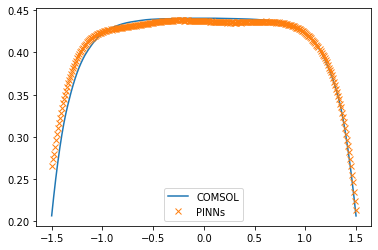

In [17]:
## 绘制对比图，z轴方向，x=0、y=0

## 绘制YZ平面，
##先使用已有的固定z坐标采样，然后，对采样平面转置，使X = 0
from matplotlib.colors import Normalize
vmin = 0
vmax = 0.8
norm = Normalize(vmin = vmin,vmax = vmax)

import pandas as pd

import cmath
filename = './result/Rop0_40_z.csv'
#df = pd.read_csv(filename, header=9, names=['x', 'y', 'z', 'Pz'])
df = pd.read_csv(filename, header=8, names=['Pz'])
## (x, y, z) u1, 20796*4

# x = np.asarray(df['x'])
# y = np.asarray(df['y'])
# z = np.asarray(df['z'])
Pz_COMSOL = np.asarray(df['Pz'])
#Pz
#len(Pz) cm, 注意单位换算，统一m
# 横坐标为了展示方便，单位cm
z_sequence = np.linspace(-1.5, 1.5, 301)

## 模型预测Z轴数据（三维）
def Sample_Z(sample_num=301, rcell=1.5):
    x = 0
    y = 0
    z_sequence = np.linspace(-rcell, rcell, sample_num)
    sample_data = []
    
    for z in z_sequence:
        sample_data.append((x, y, z))
        
    sample_data = np.asarray(sample_data, dtype=np.float32)
    return sample_data

XY_00 = Sample_Z()
#X_transpose = np.transpose(X_origin, [2, 0, 1])
y_pred_z_axis = model.predict(XY_00)[:, 0]


plt.plot(z_sequence, Pz_COMSOL, label='COMSOL')
plt.plot(z_sequence, y_pred_z_axis, marker='x',linestyle='',label='PINNs')
plt.legend()

In [16]:
# data
y_pred_test = model.predict(XY_00)
y_pred_test
a = np.asarray(df['Pz'])
a

array([0.20656004, 0.21814597, 0.22928238, 0.23996926, 0.25020661,
       0.25999444, 0.26933274, 0.27822151, 0.28666075, 0.29465047,
       0.30219066, 0.30928132, 0.31592246, 0.32211407, 0.32785615,
       0.33314871, 0.33811806, 0.34303397, 0.34776637, 0.35231524,
       0.35668059, 0.36086243, 0.36486074, 0.36867554, 0.37230664,
       0.37573492, 0.37897207, 0.38201576, 0.38488634, 0.38761668,
       0.39020676, 0.3926566 , 0.39499676, 0.39721077, 0.3991842 ,
       0.40110538, 0.40297429, 0.40479095, 0.4065381 , 0.40822857,
       0.40989375, 0.41146525, 0.41296562, 0.41439592, 0.41575617,
       0.41704637, 0.41825918, 0.41939959, 0.42046842, 0.42146567,
       0.42239134, 0.42324543, 0.42404255, 0.42488102, 0.42568212,
       0.42644487, 0.42714705, 0.42781195, 0.42843957, 0.4290239 ,
       0.42956963, 0.43007587, 0.43056644, 0.43104133, 0.43150056,
       0.43194411, 0.43237199, 0.4327842 , 0.43318075, 0.43356162,
       0.43392517, 0.43425633, 0.43457091, 0.4348689 , 0.43515

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import random


rcell = 1.5 * 1e-2
sample_num = 200

def polar_sphere_points(z, sample_num = 200):
    radius_z = np.sqrt(rcell**2 - z**2)
    sample_data = []    
    
    for theta in np.linspace(0, 2*np.pi, sample_num):
        for r in np.linspace(0, radius_z, sample_num):
            x = r * np.cos(theta)
            y = r * np.sin(theta)
            sample_data.append((x, y, z)) # 200*200 = 40000个采样点
        
    sample_data = np.asarray(sample_data, dtype=np.float32
                            )
    return sample_data



In [5]:
#x, y = X_data[:, 0], X_data[:, 1]
sample_num = 200
#z = 0.4
z_axis_list = [0.8, 0.4, 0, -0.4, -0.8]
y_pred_list = []
for z in z_axis_list:
    z = z*1e-2
    radius_z = np.sqrt(rcell**2 - z**2)
    X = polar_sphere_points(z)
    x = X[:, 0]
    y_pred = model.predict(X)[:, 0]
    y_pred_matrix = np.reshape(y_pred, (sample_num, sample_num))
    y_pred_list.append(y_pred_matrix)


theta_sequence = np.linspace(0, 2*np.pi, sample_num)
r_sequence = np.linspace(0, radius_z, sample_num)

np.savez('pred_list', data=y_pred_list)

#fig, ax = plt.subplots(1, 5, sharex='col', sharey='row')




C:\Users\Administrator\anaconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in sqrt
  del sys.path[0]
C:\Users\Administrator\anaconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:19: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
C:\Users\Administrator\anaconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
C:\Users\Administrator\anaconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:31: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calcu

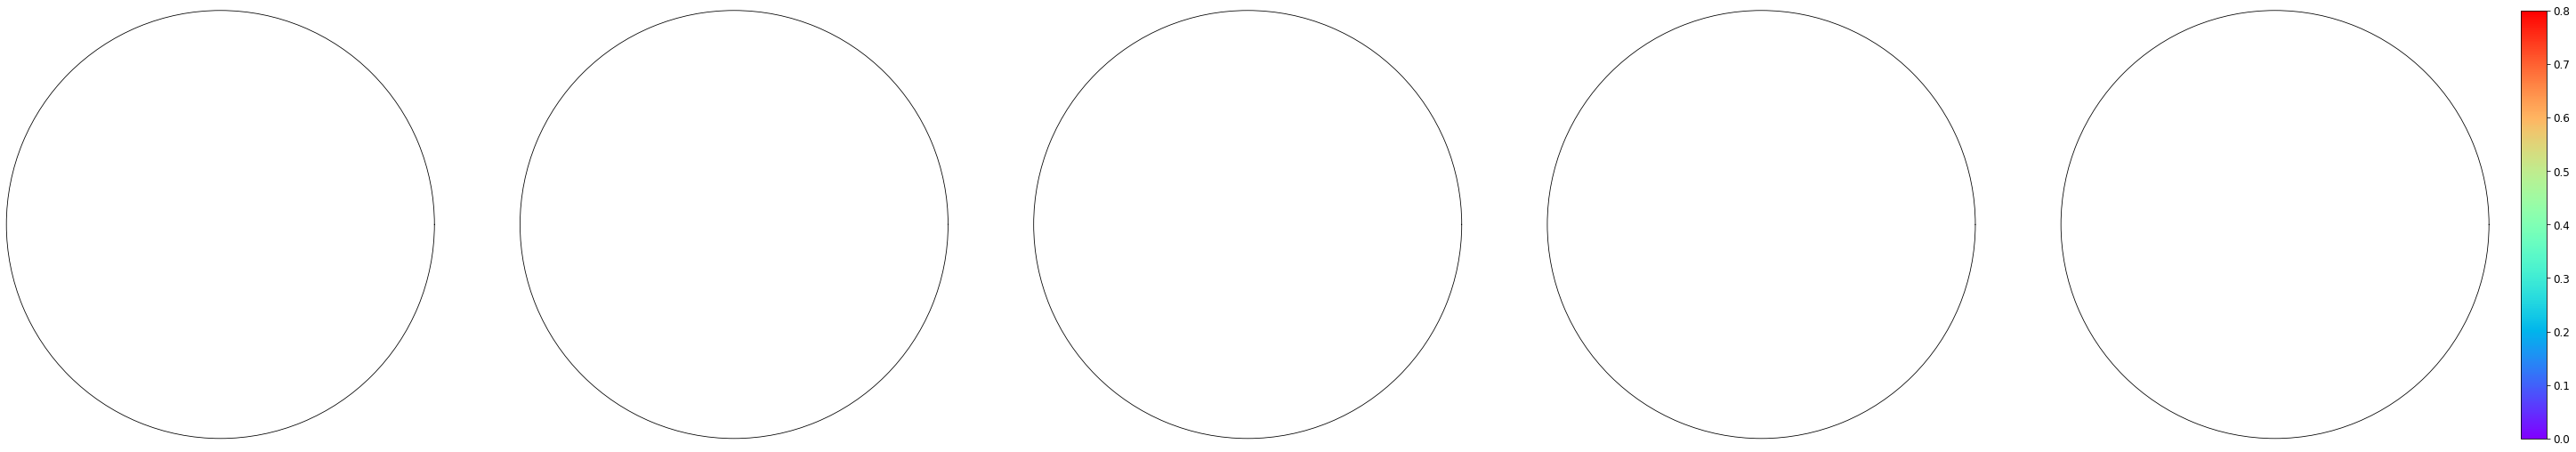

In [18]:
from matplotlib.colors import Normalize
vmin = 0
vmax = 0.8
norm = Normalize(vmin = vmin,vmax = vmax)


fig = plt.figure(figsize=(50, 10))


theta_sequence = np.linspace(0, 2*np.pi, sample_num)
#r_sequence = np.linspace(0, radius_z, sample_num)

radius_list = [np.sqrt(rcell**2 - i**2) for i in z_axis_list]


ax1 = plt.subplot(151, projection='polar')
y_pred_m = y_pred_list[0]
r_sequence = np.linspace(0, radius_list[0], sample_num)
ax1.pcolor(theta_sequence, r_sequence, y_pred_m.T, shading='auto', cmap='rainbow', norm=norm)
ax1.set_rgrids([])
ax1.set_rmax(1.5)
ax1.set_thetagrids([])
ax1.grid(False) 
#ax1.set_title('z = 0.8 cm')
#plt.colorbar(pc, shrink=.8)
#plt.grid(c='black')

ax2 = plt.subplot(152, projection='polar')
y_pred_m = y_pred_list[1]
r_sequence = np.linspace(0, radius_list[1], sample_num)
ax2.pcolor(theta_sequence, r_sequence, y_pred_m.T, shading='auto', cmap='rainbow', norm=norm)
ax2.set_rgrids([])
ax2.set_rmax(1.5)
ax2.set_thetagrids([])
#ax2.set_title('z = 0.4 cm')
#plt.colorbar(pc, shrink=.8)
#plt.grid(c='black')

ax3 = plt.subplot(153, projection='polar')
y_pred_m = y_pred_list[2]
r_sequence = np.linspace(0, radius_list[2], sample_num)
ax3.pcolor(theta_sequence, r_sequence, y_pred_m.T, shading='auto', cmap='rainbow', norm=norm)
ax3.set_rgrids([])
ax3.set_rmax(1.5)
ax3.set_thetagrids([])
#ax3.set_title('z = 0 cm')
ax3.grid(False) 

ax4 = plt.subplot(154, projection='polar')
y_pred_m = y_pred_list[3]
r_sequence = np.linspace(0, radius_list[3], sample_num)
ax4.pcolor(theta_sequence, r_sequence, y_pred_m.T, shading='auto', cmap='rainbow', norm=norm)
ax4.set_rgrids([])
ax4.set_rmax(1.5)
ax4.set_thetagrids([])
#ax4.set_title('z = -0.4 cm')

ax5 = plt.subplot(155, projection='polar')
y_pred_m = y_pred_list[4]
r_sequence = np.linspace(0, radius_list[4], sample_num)
fig5 = ax5.pcolor(theta_sequence, r_sequence, y_pred_m.T, shading='auto', cmap='rainbow', norm=norm)
ax5.set_rgrids([])
ax5.set_rmax(1.5)
ax5.set_thetagrids([])
#ax5.set_title('z = -0.8 cm')

# 调整位置，色彩棒
cax = fig.add_axes([ax5.get_position().x1+0.01,ax5.get_position().y0,0.008,ax5.get_position().height])
cb = fig.colorbar(fig5, ax=[ax1, ax2, ax3, ax4, ax5], shrink=0.7, cax=cax)
cb.ax.tick_params(labelsize=12)  #设置色标刻度字体大小。
#cb.set_label('Polarzaiton Rate', fontdict={'size':16}) ## 设置标签字体


# 设置图例字体大小


file_name = './result/test.png'
plt.savefig(file_name, dpi=320, bbox_inches='tight')
#plt.show()


In [7]:
#x, y = X_data[:, 0], X_data[:, 1]
X = random_sphere_points(z= 0.4)
x = X[:, 0]
y_pred = model.predict(X)[:, 0]
## 放到区间下，
Pz = y_pred
num_space = 100
X_lim = np.linspace(-1.5, 1.5, num_space+1)
x_space = 3/num_space
Pz_dist = np.zeros(num_space) ## Pz value add
Pz_space_num = np.zeros(num_space) ## Pz number

for x_idx in range(len(x)):
      Pz_idx = int((x[x_idx]+1.5)/x_space-1)
      Pz_dist[Pz_idx] += Pz[x_idx]
      Pz_space_num[Pz_idx] += 1

Pz_density = Pz_dist/Pz_space_num  
plt.figure()
plt.plot(Pz_density)

C:\Users\Administrator\Documents\BUAA\PINNs_SERF\draw_counter.py:39: RuntimeWarning: invalid value encountered in sqrt
  radius_z = np.sqrt(rcell**2 - z**2)


ValueError: cannot convert float NaN to integer

In [ ]:
productlog((sigm*I/(Rrel*k1))*exp((sigm*I/(Rrel*k1))+n*sigm*(z)))

In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Mon Mar 28 16:45:06 2022

@author: Administrator
绘制对比图
"""

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

file_idx = '0.4'
filename = './result/COMSOL_Rop_xy_40/z{0}.csv'.format(file_idx)
df = pd.read_csv(filename, header=9, names=['x', 'y', 'z', 'Pz'])
## (x, y, z) u1, 20796*4

x = np.asarray(df['x'])
y = np.asarray(df['y'])
z = np.asarray(df['z'])
Pz = np.asarray(df['Pz'])

## 放到区间下，
num_space = 100
X_lim = np.linspace(-1.5, 1.5, num_space+1)
x_space = 3/num_space
Pz_dist = np.zeros(num_space) ## Pz value add
Pz_space_num = np.zeros(num_space) ## Pz number

for x_idx in range(len(x)):
      Pz_idx = int((x[x_idx]+1.5)/x_space-1)
      Pz_dist[Pz_idx] += Pz[x_idx]
      Pz_space_num[Pz_idx] += 1
 
Pz_density_p = Pz_dist/Pz_space_num      
x_plot = (X_lim+x_space/2)[:-1]
p_plot = Pz_density_p
np.savez('./result/COMSOL_Rop_xy_40/Z{0}'.format(file_idx), x_axis = x_plot, polarization=p_plot)
plt.figure()      
plt.plot((X_lim+x_space/2)[:-1], Pz_density)
plt.xlim(-1.5, 1.5)
plt.show()        



location = '0.4'
COMSOL_result_path = './result/COMSOL_Rop_xy_40/Z{0}.npz'.format(location)
#pred_result_path = './draw_figures/Z{0}_pred.npz'.format(location)

COMSOL_data = np.load(COMSOL_result_path)
#pred_data = np.load(pred_result_path)



comsol_x = COMSOL_data['x_axis']
comsol_p = COMSOL_data['polarization']

#pred_x = pred_data['x_axis']
#pred_p = pred_data['polarization']

plt.figure(figsize=(10,10))
plt.plot(comsol_x, comsol_p, label='COMSOL')
## 绘制Pz_density的数据，上个单元格的结果
plt.plot(comsol_x, Pz_density, marker='x', linestyle='', label='PINNs')
plt.title('Polarization distribution at Z axis {0} cm'.format(location))
plt.legend()
plt.show()
plt.savefig('./draw_figures/polarization_dist_z_{0}.png'.format(location), dpi=320)

In [ ]:
#ax.set_rgrids([0.4, 0.8, 1.2])
##  角度、位置，顺序是不是对的呢？
#pc = ax.pcolor(theta_sequence, r_sequence, Pz_grid_mean, shading='auto', cmap='jet')
#pc = ax.pcolor(theta_sequence, r_sequence, y_pred_matrix.T, shading='auto', cmap='rainbow')

    #ax.grid(False)
    
    #ax.set_thetagrids(np.arange(0.0, 360.0, 30.0))
    #ax.grid('True')
    # vmin=1.46, vmax=1.8

    #ax.set_rgrids([0.4, 0.8, 1.2])
    #plt.grid(c='black')
    #plt.colorbar(pc, shrink=.8)